### CONFIGURATION

In [1]:
import os
import sys
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

# Deep Learning Imports
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import config

# --- CONFIGURATION ---
# 1. Path to your 4x images
INPUT_ROOT = os.path.join(config.DATASPACE, "downsampled_4x")

TEST_CORE = "Core_06"  # The difficult "spiderweb" core
CK_INDEX = 6 

BOX_SIZE = 120    # Tracking box size
STRIDE = 40       # Step size (Smaller stride = more detailed scan)
MAX_REGIONS = 3   # How many landmarks to find

2026-02-14 14:25:20.817223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1. Initialize VGG16 Model

In [3]:
print("Loading VGG16 (ImageNet weights)...")
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_pool').output)
print("Model Ready.")

Loading VGG16 (ImageNet weights)...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model Ready.


### 2. Load and Preprocess Image

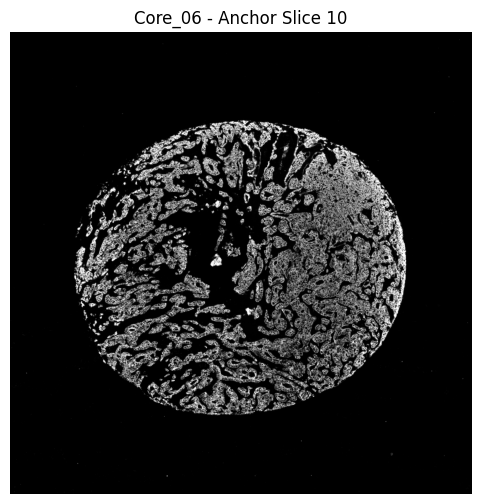

In [4]:
def robust_normalize(img):
    if img.size == 0: return img
    valid = img[img > 0]
    if valid.size == 0: return img
    p_low, p_high = np.percentile(valid, (1, 99))
    norm = np.clip((img - p_low) / (p_high - p_low + 1e-5), 0, 1)
    return (norm * 255).astype(np.uint8)

# Find Anchor Slice
core_folder = os.path.join(INPUT_ROOT, TEST_CORE)
slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
mid_idx = len(slice_files) // 2
fpath = slice_files[mid_idx]

# Load
img = tifffile.imread(fpath)
if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
else: ck = img[:, :, CK_INDEX]

# Normalize
norm_ck = robust_normalize(ck)
h, w = norm_ck.shape

# Visualize Raw
plt.figure(figsize=(6, 6))
plt.imshow(norm_ck, cmap='gray')
plt.title(f"{TEST_CORE} - Anchor Slice {mid_idx}")
plt.axis('off')
plt.show()

### 3. Scan Image and Extract Features

In [5]:
# Create Tissue Mask (Ignore background)
blur = cv2.GaussianBlur(norm_ck, (21, 21), 0)
_, tissue_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

patches = []
coords = []

# Convert to RGB (VGG16 expects 3 channels)
img_rgb = cv2.cvtColor(norm_ck, cv2.COLOR_GRAY2RGB)

print("Scanning image patches...")
for y in range(0, h - BOX_SIZE, STRIDE):
    for x in range(0, w - BOX_SIZE, STRIDE):
        # Check if patch is valid tissue
        mask_patch = tissue_mask[y:y+BOX_SIZE, x:x+BOX_SIZE]
        if np.mean(mask_patch) < 100: continue # Skip background
        
        patch = img_rgb[y:y+BOX_SIZE, x:x+BOX_SIZE]
        patches.append(patch)
        coords.append((x, y))

print(f"Extracted {len(patches)} valid tissue patches.")

# Extract Features
patches_arr = np.array(patches)
patches_pre = preprocess_input(patches_arr) # VGG-specific scaling

print("Running VGG16 Inference...")
features = model.predict(patches_pre, verbose=1)
# Flatten features: (N, 7, 7, 256) -> (N, 12544)
features_flat = features.reshape(features.shape[0], -1)

Scanning image patches...
Extracted 435 valid tissue patches.
Running VGG16 Inference...


2026-02-14 14:28:18.229001: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f889c045750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-14 14:28:18.229021: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2026-02-14 14:28:18.240177: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-14 14:28:18.299090: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

I0000 00:00:1771075699.270549   13941 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


### 4. Find the "Uniqueness" Score

In [7]:
# Calculate "Average Tissue Texture"
mean_feature = np.mean(features_flat, axis=0)

# Calculate Distance from Average (Euclidean distance in high-dim space)
distances = np.linalg.norm(features_flat - mean_feature, axis=1)

# Normalize scores for visualization (0-100)
scores_norm = (distances - distances.min()) / (distances.max() - distances.min()) * 100




 ### 5. Select and Visualize Top Landmarks

Top 3 Landmarks (Most Unique Textures):
  Landmark #1: Score 100.0/100 at (240, 600)
  Landmark #2: Score 98.6/100 at (760, 280)
  Landmark #3: Score 97.5/100 at (520, 320)


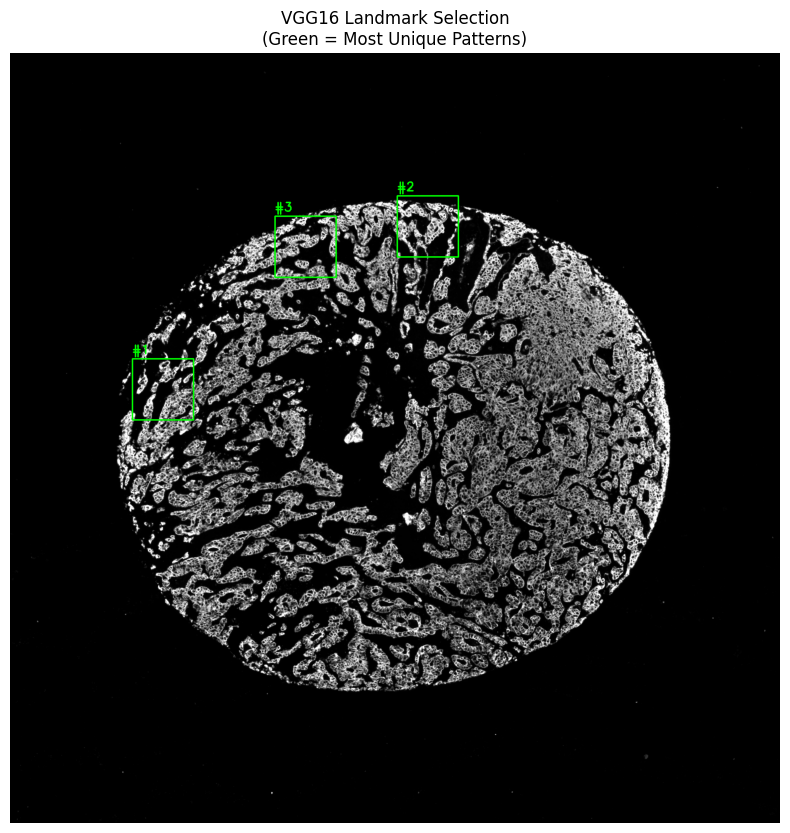

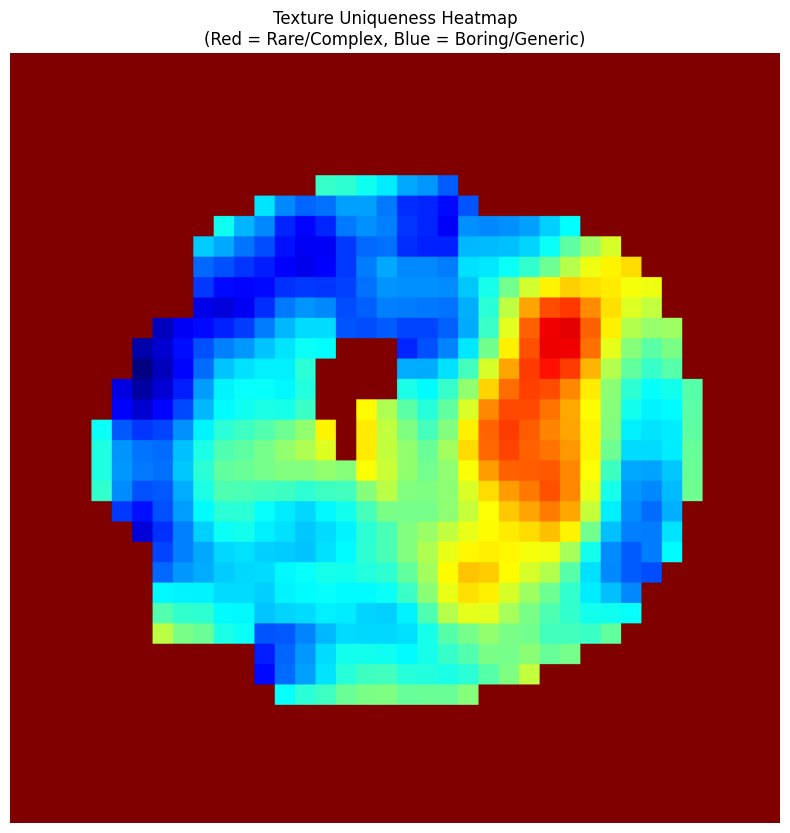

In [8]:
# We pick the top 3 patches with the highest Uniqueness Score, ensuring they aren't overlapping.


# Sort by Uniqueness (Descending)
sorted_indices = np.argsort(distances)[::-1]

found_regions = []
min_dist_px = 200 # Minimum distance between landmarks

# Copy image for drawing
vis_img = cv2.cvtColor(norm_ck, cv2.COLOR_GRAY2RGB)

print("Top 3 Landmarks (Most Unique Textures):")

for idx in sorted_indices:
    if len(found_regions) >= MAX_REGIONS: break
    
    x, y = coords[idx]
    score = scores_norm[idx]
    
    # Check overlap
    cx, cy = x + BOX_SIZE//2, y + BOX_SIZE//2
    too_close = False
    for r in found_regions:
        rx, ry = r['center']
        if np.sqrt((cx - rx)**2 + (cy - ry)**2) < min_dist_px:
            too_close = True
            break
            
    if not too_close:
        found_regions.append({'rect': (x, y, BOX_SIZE, BOX_SIZE), 'center': (cx, cy), 'score': score})
        
        # Draw on image
        cv2.rectangle(vis_img, (x, y), (x+BOX_SIZE, y+BOX_SIZE), (0, 255, 0), 2) # Green Box
        cv2.putText(vis_img, f"#{len(found_regions)}", (x, y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        
        print(f"  Landmark #{len(found_regions)}: Score {score:.1f}/100 at ({x}, {y})")

# Visualize Result
plt.figure(figsize=(10, 10))
plt.imshow(vis_img)
plt.title(f"VGG16 Landmark Selection\n(Green = Most Unique Patterns)")
plt.axis('off')
plt.show()

# Visualize Heatmap of "Uniqueness"
# Let's map the scores back to the image to see what the AI thinks is "interesting"
heatmap_vis = np.zeros((h, w), dtype=np.float32)
count_map = np.zeros((h, w), dtype=np.float32)

for i, (x, y) in enumerate(coords):
    heatmap_vis[y:y+BOX_SIZE, x:x+BOX_SIZE] += scores_norm[i]
    count_map[y:y+BOX_SIZE, x:x+BOX_SIZE] += 1

# Average out overlapping patches
heatmap_vis[count_map > 0] /= count_map[count_map > 0]
heatmap_vis = cv2.normalize(heatmap_vis, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
heatmap_color = cv2.applyColorMap(heatmap_vis, cv2.COLORMAP_JET)

plt.figure(figsize=(10, 10))
plt.imshow(heatmap_color)
plt.title("Texture Uniqueness Heatmap\n(Red = Rare/Complex, Blue = Boring/Generic)")
plt.axis('off')
plt.show()

### 6. Batch Run on ALL Cores (VGG Feature QC)

In [9]:
OUTPUT_QC_DIR = os.path.join(INPUT_ROOT, "VGG_QC_Corrected")
os.makedirs(OUTPUT_QC_DIR, exist_ok=True)

# Parameters
BATCH_BOX_SIZE = 120
BATCH_STRIDE = 60       
BATCH_MAX_REGIONS = 3
CK_INDEX = 6

# FILTERING THRESHOLDS
MIN_TISSUE_CONTENT = 0.5  # Patch must be at least 50% tissue
MIN_COMPLEXITY = 10       # Standard Deviation threshold (Kills flat background)

print(f"Starting Corrected Batch QC...")
print(f"Results will be saved to: {OUTPUT_QC_DIR}")

core_folders = sorted(glob(os.path.join(INPUT_ROOT, "Core*")))

for core_folder in tqdm(core_folders):
    core_id = os.path.basename(core_folder)
    
    # 1. Find Anchor Slice
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    if not slice_files: continue
    mid_idx = len(slice_files) // 2
    fpath = slice_files[mid_idx]
    
    try:
        # 2. Load & Preprocess
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        
        norm_ck = robust_normalize(ck)
        h, w = norm_ck.shape
        
        # Create Tissue Mask
        blur = cv2.GaussianBlur(norm_ck, (21, 21), 0)
        _, tissue_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # 3. Extract Patches (With STRICT Filtering)
        patches = []
        coords = []
        img_rgb = cv2.cvtColor(norm_ck, cv2.COLOR_GRAY2RGB)
        
        for y in range(0, h - BATCH_BOX_SIZE, BATCH_STRIDE):
            for x in range(0, w - BATCH_BOX_SIZE, BATCH_STRIDE):
                
                # Check 1: Tissue Content (Must be > 50% foreground)
                mask_patch = tissue_mask[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE]
                if np.mean(mask_patch) < (255 * MIN_TISSUE_CONTENT): continue 
                
                # Check 2: Complexity (Must not be flat black/grey)
                # This kills the "Unique Background" bug
                patch_gray = norm_ck[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE]
                if np.std(patch_gray) < MIN_COMPLEXITY: continue

                patch = img_rgb[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE]
                patches.append(patch)
                coords.append((x, y))
        
        if not patches:
            print(f"Skipping {core_id}: No valid complex tissue patches found.")
            continue
            
        # 4. VGG Inference
        patches_arr = np.array(patches)
        patches_pre = preprocess_input(patches_arr)
        
        features = model.predict(patches_pre, verbose=0)
        features_flat = features.reshape(features.shape[0], -1)
        
        # 5. Calculate Uniqueness
        mean_feature = np.mean(features_flat, axis=0)
        distances = np.linalg.norm(features_flat - mean_feature, axis=1)
        
        # Normalize scores to 0-1 range for this core
        if distances.max() - distances.min() == 0: scores_norm = distances
        else: scores_norm = (distances - distances.min()) / (distances.max() - distances.min())
        
        # 6. Select Top 3 Landmarks
        sorted_indices = np.argsort(scores_norm)[::-1]
        
        found_regions = []
        vis_img = img_rgb.copy()
        
        # Prepare Heatmap Overlay (Same size as image)
        heatmap_overlay = np.zeros((h, w), dtype=np.float32)
        count_map = np.zeros((h, w), dtype=np.float32)
        
        min_dist = 200 # Pixel distance constraint
        
        # Pick Boxes
        for idx in sorted_indices:
            x, y = coords[idx]
            score = scores_norm[idx]
            
            # Fill Heatmap data (for visualization)
            heatmap_overlay[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE] += score
            count_map[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE] += 1
            
            # Select Boxes Logic
            if len(found_regions) < BATCH_MAX_REGIONS:
                cx, cy = x + BATCH_BOX_SIZE//2, y + BATCH_BOX_SIZE//2
                too_close = False
                for r in found_regions:
                    rx, ry = r['center']
                    if np.sqrt((cx - rx)**2 + (cy - ry)**2) < min_dist:
                        too_close = True
                        break
                
                if not too_close:
                    found_regions.append({'rect': (x, y), 'center': (cx, cy)})
                    # Draw Green Box
                    cv2.rectangle(vis_img, (x, y), (x+BATCH_BOX_SIZE, y+BATCH_BOX_SIZE), (0, 255, 0), 4)
                    cv2.putText(vis_img, str(len(found_regions)), (x, y-10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)

        # 7. Generate Proper Heatmap (Masked)
        # Average overlapping strides
        mask_valid = count_map > 0
        heatmap_overlay[mask_valid] /= count_map[mask_valid]
        
        # Normalize to 0-255
        heatmap_uint8 = cv2.normalize(heatmap_overlay, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        # Apply Jet Colormap
        heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
        
        # Black out the background (Zero score areas)
        # This fixes the "Red Background" visual bug
        heatmap_color[count_map == 0] = 0 
        
        # Blend: 70% Original Image + 30% Heatmap
        blended = cv2.addWeighted(img_rgb, 0.7, heatmap_color, 0.3, 0)

        # 8. Save Visualization
        save_path = os.path.join(OUTPUT_QC_DIR, f"{core_id}_VGG_Fixed.jpg")
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        # Left: Green Boxes on Raw
        ax[0].imshow(vis_img)
        ax[0].set_title(f"Selected Landmarks (Green)")
        ax[0].axis('off')
        
        # Right: Heatmap Overlay
        ax[1].imshow(blended)
        ax[1].set_title(f"Feature Uniqueness Heatmap\n(Red=Unique, Blue=Common)")
        ax[1].axis('off')
        
        plt.savefig(save_path, bbox_inches='tight', dpi=100)
        plt.close(fig)

    except Exception as e:
        print(f"Failed {core_id}: {e}")
        import traceback
        traceback.print_exc()

print("Corrected QC Run Complete. Check 'VGG_QC_Corrected' folder.")

Starting Corrected Batch QC...
Results will be saved to: /data3/junming/3D-TMA-Register/downsampled_4x/VGG_QC_Corrected


 30%|███       | 9/30 [00:16<00:39,  1.90s/it]

Skipping Core_10: No valid complex tissue patches found.


 50%|█████     | 15/30 [00:22<00:18,  1.20s/it]

Skipping Core_16: No valid complex tissue patches found.


 87%|████████▋ | 26/30 [00:36<00:06,  1.63s/it]

Skipping Core_27: No valid complex tissue patches found.


100%|██████████| 30/30 [00:41<00:00,  1.39s/it]

Corrected QC Run Complete. Check 'VGG_QC_Corrected' folder.


### 7. The "Feature Energy" Fix

In [10]:

import os
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import preprocess_input

# --- CONFIGURATION ---
OUTPUT_QC_DIR = os.path.join(INPUT_ROOT, "VGG_Energy_QC")
os.makedirs(OUTPUT_QC_DIR, exist_ok=True)

# Parameters
BATCH_BOX_SIZE = 120
BATCH_STRIDE = 60       
BATCH_MAX_REGIONS = 3
CK_INDEX = 6

print(f"Starting Feature Energy Scan (High Texture Priority)...")

core_folders = sorted(glob(os.path.join(INPUT_ROOT, "Core*")))

for core_folder in tqdm(core_folders):
    core_id = os.path.basename(core_folder)
    
    # 1. Find Anchor
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    if not slice_files: continue
    mid_idx = len(slice_files) // 2
    fpath = slice_files[mid_idx]
    
    try:
        # 2. Load & Normalize
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        
        norm_ck = robust_normalize(ck)
        h, w = norm_ck.shape
        
        # 3. Extract Patches
        patches = []
        coords = []
        img_rgb = cv2.cvtColor(norm_ck, cv2.COLOR_GRAY2RGB)
        
        # Simple Mask to skip pure black background
        blur = cv2.GaussianBlur(norm_ck, (21, 21), 0)
        _, tissue_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        for y in range(0, h - BATCH_BOX_SIZE, BATCH_STRIDE):
            for x in range(0, w - BATCH_BOX_SIZE, BATCH_STRIDE):
                # Must be mostly tissue
                if np.mean(tissue_mask[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE]) < 127: continue
                
                patch = img_rgb[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE]
                patches.append(patch)
                coords.append((x, y))
        
        if not patches: continue
            
        # 4. VGG Inference
        patches_arr = np.array(patches)
        patches_pre = preprocess_input(patches_arr)
        
        features = model.predict(patches_pre, verbose=0)
        features_flat = features.reshape(features.shape[0], -1)
        
        # --- THE LOGIC SWAP IS HERE ---
        # Old: Distance from Mean (Uniqueness)
        # New: L2 Norm (Energy / Strength)
        # We calculate the magnitude of the feature vector. Stronger texture = Higher Magnitude.
        energy_scores = np.linalg.norm(features_flat, axis=1)
        
        # Normalize 0-1
        scores_norm = (energy_scores - energy_scores.min()) / (energy_scores.max() - energy_scores.min())
        
        # 5. Visualization & Selection
        sorted_indices = np.argsort(scores_norm)[::-1] # Highest Energy First
        
        vis_img = img_rgb.copy()
        heatmap_overlay = np.zeros((h, w), dtype=np.float32)
        count_map = np.zeros((h, w), dtype=np.float32)
        
        found_regions = []
        min_dist = 150 # slightly closer allows picking adjacent strong webs
        
        for idx in sorted_indices:
            x, y = coords[idx]
            score = scores_norm[idx]
            
            # Fill heatmap
            heatmap_overlay[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE] += score
            count_map[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE] += 1
            
            # Pick Landmarks
            if len(found_regions) < BATCH_MAX_REGIONS:
                cx, cy = x + BATCH_BOX_SIZE//2, y + BATCH_BOX_SIZE//2
                
                too_close = False
                for r in found_regions:
                    rx, ry = r['center']
                    if np.sqrt((cx - rx)**2 + (cy - ry)**2) < min_dist:
                        too_close = True
                        break
                
                if not too_close:
                    found_regions.append({'rect': (x, y), 'center': (cx, cy)})
                    cv2.rectangle(vis_img, (x, y), (x+BATCH_BOX_SIZE, y+BATCH_BOX_SIZE), (0, 255, 0), 4)

        # Process Heatmap
        mask_valid = count_map > 0
        heatmap_overlay[mask_valid] /= count_map[mask_valid]
        heatmap_uint8 = (heatmap_overlay * 255).astype(np.uint8)
        heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
        heatmap_color[count_map == 0] = 0 # Black background
        
        blended = cv2.addWeighted(img_rgb, 0.6, heatmap_color, 0.4, 0)
        
        # Save
        save_path = os.path.join(OUTPUT_QC_DIR, f"{core_id}_Energy.jpg")
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(vis_img)
        ax[0].set_title("Highest 'Energy' Patches")
        ax[0].axis('off')
        
        ax[1].imshow(blended)
        ax[1].set_title("Texture Energy Heatmap\n(Red = Strong Web, Blue = Weak)")
        ax[1].axis('off')
        
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)

    except Exception as e:
        print(f"Failed {core_id}: {e}")

print("Done. Check 'VGG_Energy_QC'.")

Starting Feature Energy Scan (High Texture Priority)...


 53%|█████▎    | 16/30 [00:17<00:10,  1.32it/s]/tmp/ipykernel_13320/3971111598.py:76: RuntimeWarning: invalid value encountered in divide
  scores_norm = (energy_scores - energy_scores.min()) / (energy_scores.max() - energy_scores.min())
/tmp/ipykernel_13320/3971111598.py:114: RuntimeWarning: invalid value encountered in cast
  heatmap_uint8 = (heatmap_overlay * 255).astype(np.uint8)
 93%|█████████▎| 28/30 [00:30<00:02,  1.18s/it]/tmp/ipykernel_13320/3971111598.py:76: RuntimeWarning: invalid value encountered in divide
  scores_norm = (energy_scores - energy_scores.min()) / (energy_scores.max() - energy_scores.min())
/tmp/ipykernel_13320/3971111598.py:114: RuntimeWarning: invalid value encountered in cast
  heatmap_uint8 = (heatmap_overlay * 255).astype(np.uint8)
100%|██████████| 30/30 [00:32<00:00,  1.08s/it]

Done. Check 'VGG_Energy_QC'.


### 9. VGG-Guided Shape Discovery ("Spot & Snap")

In [11]:

# 1. Use VGG Heatmap to find the "loudest" texture.
# 2. Use Local Thresholding to draw the EXACT shape of that texture (No more boxes).


import os
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

# --- CONFIGURATION ---

OUTPUT_QC_DIR = os.path.join(INPUT_ROOT, "VGG_Contours_QC")
os.makedirs(OUTPUT_QC_DIR, exist_ok=True)

# Parameters
BATCH_BOX_SIZE = 120
BATCH_STRIDE = 30
BATCH_MAX_REGIONS = 3
CK_INDEX = 6

# Initialize Model
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_pool').output)

def robust_normalize(img):
    if img.size == 0: return img
    valid = img[img > 0]
    if valid.size == 0: return img
    p_low, p_high = np.percentile(valid, (1, 99))
    norm = np.clip((img - p_low) / (p_high - p_low + 1e-5), 0, 1)
    return (norm * 255).astype(np.uint8)

def get_precise_contour(crop_img):
    """
    Takes a small VGG patch and finds the largest organic object inside it.
    Replaces the 'Box' with a 'Shape'.
    """
    # 1. Blur to merge the spiderweb strands slightly
    blur = cv2.GaussianBlur(crop_img, (11, 11), 0)
    
    # 2. Otsu Thresholding (Automatic "Dark vs Bright" split)
    _, bin_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 3. Find Contours
    contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours: return None
    
    # 4. Keep the largest blob in the center
    # We prefer the blob closest to the center of the patch
    h, w = crop_img.shape
    center = (w//2, h//2)
    
    best_cnt = None
    min_dist = float('inf')
    
    for cnt in contours:
        if cv2.contourArea(cnt) < 200: continue # Ignore noise
        
        M = cv2.moments(cnt)
        if M["m00"] == 0: continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        
        dist = np.sqrt((cx - center[0])**2 + (cy - center[1])**2)
        if dist < min_dist:
            min_dist = dist
            best_cnt = cnt
            
    return best_cnt

print(f"Starting VGG-Guided Contour Discovery...")

core_folders = sorted(glob(os.path.join(INPUT_ROOT, "Core*")))

for core_folder in tqdm(core_folders):
    core_id = os.path.basename(core_folder)
    
    # 1. Find Anchor
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    if not slice_files: continue
    mid_idx = len(slice_files) // 2
    fpath = slice_files[mid_idx]
    
    try:
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        norm_ck = robust_normalize(ck)
        h, w = norm_ck.shape
        img_rgb = cv2.cvtColor(norm_ck, cv2.COLOR_GRAY2RGB)
        
        # 2. Build VGG Heatmap (Same as before)
        blur = cv2.GaussianBlur(norm_ck, (21, 21), 0)
        _, tissue_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        patches = []
        coords = []
        for y in range(0, h - BATCH_BOX_SIZE, BATCH_STRIDE):
            for x in range(0, w - BATCH_BOX_SIZE, BATCH_STRIDE):
                if np.mean(tissue_mask[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE]) < 127: continue
                patch = img_rgb[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE]
                patches.append(patch)
                coords.append((x, y))
        
        if not patches: continue
            
        features = model.predict(preprocess_input(np.array(patches)), verbose=0)
        features_flat = features.reshape(features.shape[0], -1)
        energy_scores = np.linalg.norm(features_flat, axis=1)
        
        # Build Heatmap
        heatmap_accum = np.zeros((h, w), dtype=np.float32)
        count_map = np.zeros((h, w), dtype=np.float32)
        for idx, (x, y) in enumerate(coords):
            heatmap_accum[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE] += energy_scores[idx]
            count_map[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE] += 1
            
        mask_valid = count_map > 0
        heatmap_avg = np.zeros_like(heatmap_accum)
        heatmap_avg[mask_valid] = heatmap_accum[mask_valid] / count_map[mask_valid]
        
        # 3. Find Peaks & Draw CONTOURS
        vis_img = img_rgb.copy()
        search_map = heatmap_avg.copy()
        
        found = 0
        for _ in range(BATCH_MAX_REGIONS):
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(search_map)
            if max_val <= 0: break
            
            cx, cy = max_loc
            x = max(0, cx - BATCH_BOX_SIZE//2)
            y = max(0, cy - BATCH_BOX_SIZE//2)
            
            # Crop the "High Energy" Patch
            patch_crop = norm_ck[y:y+BATCH_BOX_SIZE, x:x+BATCH_BOX_SIZE]
            
            # --- THE MAGIC STEP: Get the Shape ---
            contour = get_precise_contour(patch_crop)
            
            if contour is not None:
                # Offset contour to global coordinates
                contour += np.array([x, y])
                
                # Draw Outline (Cyan, thickness 2)
                cv2.drawContours(vis_img, [contour], -1, (0, 255, 255), 2)
                
                # Draw Center Dot
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    mcx = int(M["m10"] / M["m00"])
                    mcy = int(M["m01"] / M["m00"])
                    cv2.circle(vis_img, (mcx, mcy), 5, (0, 0, 255), -1)
                
                found += 1
            
            # Black out search area
            cv2.circle(search_map, (cx, cy), BATCH_BOX_SIZE, 0, -1)
            
        # Save
        save_path = os.path.join(OUTPUT_QC_DIR, f"{core_id}_Contours.jpg")
        
        heatmap_uint8 = cv2.normalize(heatmap_avg, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
        heatmap_color[count_map == 0] = 0
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(vis_img)
        ax[0].set_title("VGG-Guided Precise Shapes")
        ax[0].axis('off')
        ax[1].imshow(heatmap_color)
        ax[1].set_title("Texture Energy Heatmap")
        ax[1].axis('off')
        
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)

    except Exception as e:
        print(f"Failed {core_id}: {e}")

print("Done. Check 'VGG_Contours_QC'.")

Starting VGG-Guided Contour Discovery...


100%|██████████| 30/30 [00:49<00:00,  1.67s/it]

Done. Check 'VGG_Contours_QC'.
